In [95]:
import pandas as pd
import numpy as np


# Import Data

In [145]:
data = pd.read_csv("data/data_clean.csv", index_col = False)

In [146]:
categories = ["property_type","product_depth"]
data[categories] = data[categories].apply(lambda x: x.astype("category"))

In [147]:
data.dtypes

building_size      float64
land_size          float64
price              float64
bedroom_count      float64
bathroom_count     float64
parking_count      float64
property_type     category
product_depth     category
dtype: object

In [148]:
data

,building_size,land_size,price,bedroom_count,bathroom_count,parking_count,property_type,product_depth
0,213.0,801.0,435000.0,2.0,1.0,1.0,House,premiere
1,171.0,164.5,320000.0,3.0,2.0,2.0,Apartment,premiere
2,98.0,127.0,310000.0,2.0,1.0,1.0,Unit,premiere
3,213.0,801.0,259000.0,1.0,1.0,0.0,House,premiere
4,201.0,127.0,439000.0,3.0,2.0,2.0,Unit,premiere
...,...,...,...,...,...,...,...,...
671,213.0,801.0,495000.0,4.0,2.0,2.0,House,feature
672,203.0,600.0,601000.0,4.0,2.0,2.0,House,standard
673,209.6,800.0,655000.0,4.0,2.0,2.0,House,standard
674,180.0,450.0,675000.0,4.0,2.0,3.0,House,standard


In [149]:
X = data.drop("price", axis = 1)
y = data["price"]

In [150]:
data["property_type"].value_counts()

House                   293
Unit                    178
Apartment               164
Townhouse                25
Duplex/Semi-detached     16
Name: property_type, dtype: int64

In [151]:
data["product_depth"].value_counts()

premiere    411
feature     141
standard    124
Name: product_depth, dtype: int64

In [152]:
data.isna().sum()

building_size     0
land_size         0
price             0
bedroom_count     0
bathroom_count    0
parking_count     0
property_type     0
product_depth     0
dtype: int64

# Data Pipeline(s)

In [153]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [155]:
X_train.head()

,building_size,land_size,bedroom_count,bathroom_count,parking_count,property_type,product_depth
36,130.0,164.5,2.0,2.0,2.0,Apartment,premiere
45,135.0,164.5,2.0,2.0,1.0,Apartment,feature
628,213.0,801.0,3.0,1.0,2.0,House,premiere
156,213.0,450.0,4.0,2.0,2.0,House,premiere
41,135.0,260.0,3.0,2.0,2.0,Apartment,premiere


In [156]:
# set up scaling step for numerical columns
nums = X.drop(categories, axis = 1).columns
num_trans = Pipeline(
    steps = [("scaler", StandardScaler())]
)

In [157]:
# set up one hot encoder for categorical variables
cat_trans = OneHotEncoder(handle_unknown = "ignore")

In [158]:
# combine scaling and encoding into a single column transformer
processor = ColumnTransformer(
    transformers = [
        ("num", num_trans, nums),
        ("cat", cat_trans, categories)
    ]

)

# Models

## Baseline Model (Linear)

In [159]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [160]:
# linear pipeline
lm = Pipeline(
    steps = [("preprocessor", processor), ("lm", LinearRegression())]
)

In [161]:
lm.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['building_size', 'land_size', 'bedroom_count', 'bathroom_count',
       'parking_count'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type',
                                                   'product_depth'])])),
                ('lm', LinearRegression())])

In [162]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [163]:
print("Linear Model Metrics (train)")
print("R-squared score: "+ str(r2_score(y_train, y_train_pred)))
print("RMSE: "+ str(mean_squared_error(y_train, y_train_pred)))
print("MAE: "+ str(mean_absolute_error(y_train, y_train_pred)))

Linear Model Metrics (train)
R-squared score: 0.5710368043063985
RMSE: 10978396808.74275
MAE: 80879.12901755983


In [164]:
print("Linear Model Metrics (test)")
print("R-squared score: "+ str(r2_score(y_test, y_test_pred)))
print("RMSE: "+ str(mean_squared_error(y_test, y_test_pred)))
print("MAE: "+ str(mean_absolute_error(y_test, y_test_pred)))

Linear Model Metrics (test)
R-squared score: 0.5261716543234063
RMSE: 11538854229.919594
MAE: 82130.62692940608


## Decision Tree

In [165]:
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [166]:
#splitter = "random"
regress_dt = DecisionTreeRegressor(random_state = 123)

In [167]:
# decision tree pipeline
dt = Pipeline(
    steps = [("preprocessor", processor), ("model", regress_dt)]
)

# determine best parameters
param_grid = {
    'model__ccp_alpha': [0.01, 0.02, 0.03],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [5, 10, 20],
    'model__min_samples_leaf':[5, 10, 15],
    'model__max_features':["auto", "sqrt", "log2"] 
}

dt_test = GridSearchCV(dt, param_grid, cv=5)
dt_test.fit(X_train, y_train)

dt_test.best_params_

{'model__ccp_alpha': 0.01,
 'model__max_depth': 5,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 20}

In [168]:
# building pipeline with best params
regress_dt2 = DecisionTreeRegressor(ccp_alpha = 0.01, max_depth = 5, min_samples_split = 5, 
                                 min_samples_leaf = 5, random_state = 123)
dt2 = Pipeline(
    steps = [("preprocessor", processor), ("model", regress_dt2)]
)

In [169]:
# fitting data
dt2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['building_size', 'land_size', 'bedroom_count', 'bathroom_count',
       'parking_count'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type',
                                                   'product_depth'])])),
                ('model',
                 DecisionTreeRegressor(ccp_alpha=0.01, max_depth=5,
                                       min_samples_leaf=5, min_samples_split=5,
                                       random_state=123))])

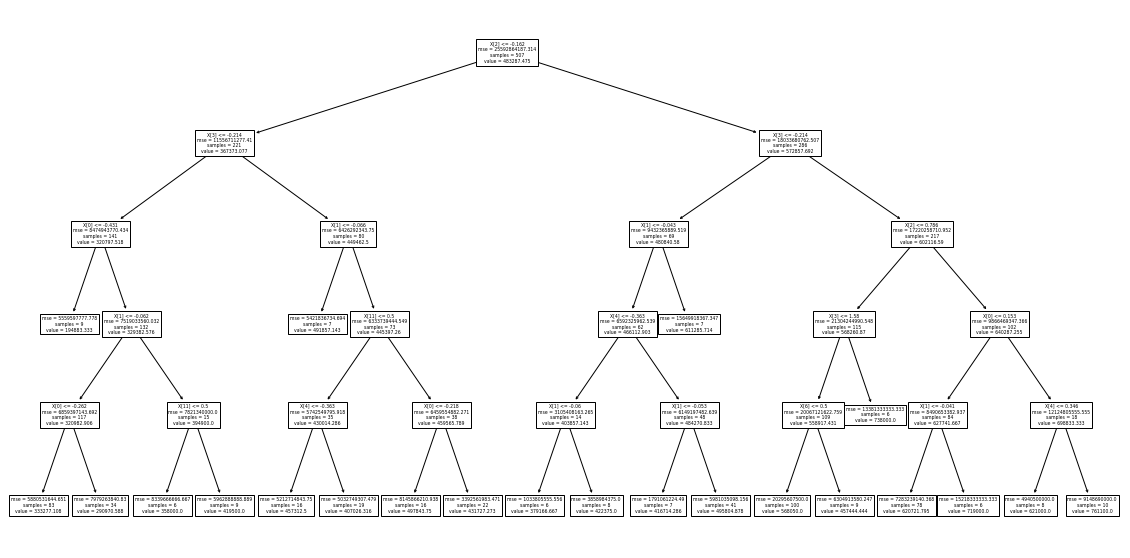

In [170]:
# viewing model
plt.figure(figsize = (20, 10))
plot_tree(dt2["model"])
plt.show()

In [171]:
y_train_pred2 = dt2.predict(X_train)
y_test_pred2 = dt2.predict(X_test)

In [172]:
print("Decision Tree Model Metrics (train)")
print("R-squared score: "+ str(r2_score(y_train, y_train_pred2)))
print("RMSE: "+ str(mean_squared_error(y_train, y_train_pred2)))
print("MAE: "+ str(mean_absolute_error(y_train, y_train_pred2)))

Decision Tree Model Metrics (train)
R-squared score: 0.6380540996530818
RMSE: 9263232270.73394
MAE: 74615.46621719285


In [173]:
# overfitting issues- change model to use more regularization
print("Decision Tree Model Metrics (test)")
print("R-squared score: "+ str(r2_score(y_test, y_test_pred2)))
print("RMSE: "+ str(mean_squared_error(y_test, y_test_pred2)))
print("MAE: "+ str(mean_absolute_error(y_test, y_test_pred2)))

Decision Tree Model Metrics (test)
R-squared score: 0.4878966567759936
RMSE: 12470942023.69538
MAE: 84716.99114663064


In [174]:
regress_dt3 = DecisionTreeRegressor(ccp_alpha = 0.01, max_depth = 5, min_samples_split = 20, 
                                 min_samples_leaf = 5, random_state = 123, max_features = "sqrt")
dt3 = Pipeline(
    steps = [("preprocessor", processor), ("model", regress_dt3)]
)

dt3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['building_size', 'land_size', 'bedroom_count', 'bathroom_count',
       'parking_count'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type',
                                                   'product_depth'])])),
                ('model',
                 DecisionTreeRegressor(ccp_alpha=0.01, max_depth=5,
                                       max_features='sqrt', min_samples_leaf=5,
                                       min_samples_split=20,
                                       random_state

In [175]:
y_train_pred3 = dt3.predict(X_train)
y_test_pred3 = dt3.predict(X_test)

In [176]:
print("Decision Tree Model Metrics (train)")
print("R-squared score: "+ str(r2_score(y_train, y_train_pred3)))
print("RMSE: "+ str(mean_squared_error(y_train, y_train_pred3)))
print("MAE: "+ str(mean_absolute_error(y_train, y_train_pred3)))

Decision Tree Model Metrics (train)
R-squared score: 0.5142952116312761
RMSE: 12430576683.849073
MAE: 84368.60373348954


In [177]:
# overfitting under control, but worse performance
print("Decision Tree Model Metrics (test)")
print("R-squared score: "+ str(r2_score(y_test, y_test_pred3)))
print("RMSE: "+ str(mean_squared_error(y_test, y_test_pred3)))
print("MAE: "+ str(mean_absolute_error(y_test, y_test_pred3)))

Decision Tree Model Metrics (test)
R-squared score: 0.44616331083938476
RMSE: 13487248877.608286
MAE: 88203.28642476659


## Gradient Boosting Regressor

In [178]:
from sklearn.ensemble import GradientBoostingRegressor

In [179]:
regress_gb = GradientBoostingRegressor(random_state = 123)

In [180]:
# decision tree pipeline
gb = Pipeline(
    steps = [("preprocessor", processor), ("model", regress_gb)]
)

# determine best parameters
param_grid = {
    'model__ccp_alpha': [0.01, 0.02, 0.03],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [5, 10, 20],
    'model__min_samples_leaf':[5, 10, 15],
    'model__max_features':["auto", "sqrt", "log2"]
}

gb_test = GridSearchCV(gb, param_grid, cv=5)
gb_test.fit(X_train, y_train)

gb_test.best_params_

{'model__ccp_alpha': 0.01,
 'model__max_depth': 3,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 20}

In [181]:
regress_gb2 = GradientBoostingRegressor(random_state = 123, ccp_alpha = 0.01, 
                                     max_depth = 3, min_samples_leaf = 5, 
                                    min_samples_split = 20, max_features = "sqrt")
gb2 = Pipeline(
    steps = [("preprocessor", processor), ("model", regress_gb2)]
)

In [182]:
gb2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['building_size', 'land_size', 'bedroom_count', 'bathroom_count',
       'parking_count'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type',
                                                   'product_depth'])])),
                ('model',
                 GradientBoostingRegressor(ccp_alpha=0.01, max_features='sqrt',
                                           min_samples_leaf=5,
                                           min_samples_split=20,
                                           random_st

In [183]:
y_train_pred4 = gb2.predict(X_train)
y_test_pred4 = gb2.predict(X_test)

In [184]:
print("Gradient Boosting Model Metrics (train)")
print("R-squared score: "+ str(r2_score(y_train, y_train_pred4)))
print("RMSE: "+ str(mean_squared_error(y_train, y_train_pred4)))
print("MAE: "+ str(mean_absolute_error(y_train, y_train_pred4)))

Gradient Boosting Model Metrics (train)
R-squared score: 0.7096967347572181
RMSE: 7429692040.492454
MAE: 66509.52770608747


In [185]:
# overfitting issues- change model to use more regularization
print("Gradient Boosting  Model Metrics (test)")
print("R-squared score: "+ str(r2_score(y_test, y_test_pred4)))
print("RMSE: "+ str(mean_squared_error(y_test, y_test_pred4)))
print("MAE: "+ str(mean_absolute_error(y_test, y_test_pred4)))

Gradient Boosting  Model Metrics (test)
R-squared score: 0.5797913464706179
RMSE: 10233086398.20331
MAE: 76578.6102750811


In [186]:
# add subsample to deal with overfitting
regress_gb3 = GradientBoostingRegressor(random_state = 123, ccp_alpha = 0.01, 
                                     max_depth = 3, min_samples_leaf = 5, 
                                    min_samples_split = 20, max_features = "sqrt",
                                       subsample = 0.09)
gb3 = Pipeline(
    steps = [("preprocessor", processor), ("model", regress_gb3)]
)

In [187]:
gb3.fit(X_train, y_train)
y_train_pred5 = gb3.predict(X_train)
y_test_pred5 = gb3.predict(X_test)

In [188]:
print("Gradient Boosting Model Metrics (train)")
print("R-squared score: "+ str(r2_score(y_train, y_train_pred5)))
print("RMSE: "+ str(mean_squared_error(y_train, y_train_pred5)))
print("MAE: "+ str(mean_absolute_error(y_train, y_train_pred5)))

Gradient Boosting Model Metrics (train)
R-squared score: 0.5980540217950634
RMSE: 10286948830.83621
MAE: 79882.75052983368


In [189]:
# the best model we can get at this point
print("Gradient Boosting  Model Metrics (test)")
print("R-squared score: "+ str(r2_score(y_test, y_test_pred5)))
print("RMSE: "+ str(mean_squared_error(y_test, y_test_pred5)))
print("MAE: "+ str(mean_absolute_error(y_test, y_test_pred5)))

Gradient Boosting  Model Metrics (test)
R-squared score: 0.5327160656210936
RMSE: 11379482152.09081
MAE: 82986.16017322204
